# Events visualization

> [Laboratory of Biomechanics and Motor Control](http://pesquisa.ufabc.edu.br/bmclab)   
> Federal University of ABC, Brazil

In [11]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
#matplotlib.rcParams['figure.dpi'] = 300  # inline figure resolution
#matplotlib.rc("savefig", dpi=300)        # saved figure resolution
import seaborn as sns
sns.set_style('whitegrid')
from ipywidgets import widgets, Layout
import glob
import sys, os

## Information about the data files

In [2]:
# path of the dataset files
path2 = r'/mnt/DATA/X/GEDS/figshare'
# data sampling frequency
freq = 1000
# headers in the data files
sn = ['Time',
      'EMG_taR',
      'ACCx_taR', 'ACCy_taR', 'ACCz_taR', 'GYRx_taR', 'GYRy_taR', 'GYRz_taR',
      'MAGx_taR', 'MAGy_taR', 'MAGz_taR',
      'ACCx_tbR', 'ACCy_tbR', 'ACCz_tbR', 'GYRx_tbR', 'GYRy_tbR', 'GYRz_tbR',
      'MAGx_tbR', 'MAGy_tbR', 'MAGz_tbR',
      'EMG_taL',
      'ACCx_taL', 'ACCy_taL', 'ACCz_taL', 'GYRx_taL', 'GYRy_taL', 'GYRz_taL',
      'MAGx_taL', 'MAGy_taL', 'MAGz_taL',
      'ACCx_tbL', 'ACCy_tbL', 'ACCz_tbL', 'GYRx_tbL', 'GYRy_tbL', 'GYRz_tbL',
      'MAGx_tbL', 'MAGy_tbL', 'MAGz_tbL',
      'FSR_hsR', 'FSR_toR',
      'FSR_hsL', 'FSR_toL']
# files in the directory:
filenames = glob.glob(os.path.join(path2, 'S*[0-9]', 's*[1-6].txt'))
filenames.sort()
print('Number of files in dataset:', len(filenames))

Number of files in dataset: 414


## Events files

In [3]:
# files in the directory:
filenames = glob.glob(os.path.join(path2, 'S*[0-9]', 's*ev.txt'))
filenames.sort()
filenames_c = glob.glob(os.path.join(path2, 'S*[0-9]', 's*c*ev.txt'))
filenames_c.sort()
filenames_f = glob.glob(os.path.join(path2, 'S*[0-9]', 's*f*ev.txt'))
filenames_f.sort()
filenames_s = glob.glob(os.path.join(path2, 'S*[0-9]', 's*s*ev.txt'))
filenames_s.sort()
print('Total number of files:', len(filenames))
print('Number of bc files:', len(filenames_c))
print('Number of bf files:', len(filenames_f))
print('Number of bs files:', len(filenames_s))
#print(filenames_s[0])

Total number of files: 414
Number of bc files: 138
Number of bf files: 138
Number of bs files: 138


## Spatio-temporal calculations based on the events files

In [4]:
# header of the events file
header = 'RHS\tRHO\tLTS\tLTO\tLHS\tLHO\tRTS\tRTO'
# spatio-temporal variables
vars_str = ['step_l', 'stride_l', 'support_l',
            'step_r', 'stride_r', 'support_r', 'stride_len', 'speed']

def read_data2(fname, debug=False):
    """read file with events data.
    """
    # the parameter na_values=0 below will replace 0 by NaN
    df = pd.read_csv(fname, sep='\t', header=0, index_col=None, na_values=0, engine='c')
    if debug:
        print('Data shape: ({0}, {1})'.format(*df.shape))

    return df


def calc_vars(df):
    """ calculate spatio-temporal variables 
        RHS RHO LTS LTO LHS LHO RTS RTO
    """
    freq = 1000  # Hz
    walkway_len = 40  # meters
    # drop first and last strides
    df = df.iloc[1:-1]  
    df.reset_index(drop=True, inplace=True)
    
    step_l = (df.RHS[1:] - df.LHS[:-1].values)/freq
    stride_l = (df.LHS.diff())/freq    
    support_l = (df.LTO[1:] - df.LHS[:-1].values)/freq
    step_r = (df.LHS[:-1] - df.RHS[:-1])/freq
    stride_r = (df.RHS.diff())/freq
    support_r = (df.RTO[:-1] - df.RHS[:-1])/freq
    
    stride_len = [walkway_len / (stride_r.shape[0]-1)]
    speed = [walkway_len / ((df.RHS.iloc[-1]-df.RHS.iloc[0])/freq)]
       
    return [step_l, stride_l, support_l, step_r, stride_r, support_r, stride_len, speed]  


def s_calc_vars(subject, filenames_c, filenames_f, filenames_s):
    """ calculate spatio-temporal variables for a subject
    """
    vars_c = [[], [], [], [], [], [], [], []]
    vars_f = [[], [], [], [], [], [], [], []]
    vars_s = [[], [], [], [], [], [], [], []]
    for s in subject:
        for i in range(1, 6):
            i += int(6*s)
            df_c = read_data2(filenames_c[i], debug=False)
            df_f = read_data2(filenames_f[i], debug=False)
            df_s = read_data2(filenames_s[i], debug=False)
            vars_ci = calc_vars(df_c)
            vars_c = [np.concatenate((varsi, vi)) for varsi, vi in zip(vars_c, vars_ci)]
            vars_fi = calc_vars(df_f)
            vars_f = [np.concatenate((varsi, vi)) for varsi, vi in zip(vars_f, vars_fi)]
            vars_si = calc_vars(df_s)
            vars_s = [np.concatenate((varsi, vi)) for varsi, vi in zip(vars_s, vars_si)] 
            
    return vars_c, vars_f, vars_s

## Boxplot of the spatio-temporal data (with widget to select subject)

<IPython.core.display.Javascript object>


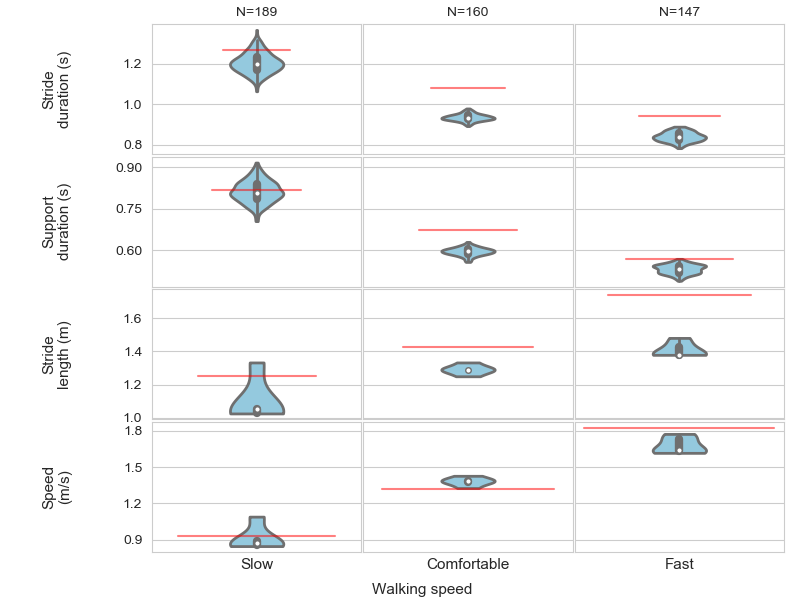

In [5]:
def boxplot(axs, vars_c, vars_f, vars_s, vars_str):
    """boxplot for spatio-temporal variables
    """
    vars_str = ['Stride\nduration (s)', 'Support\nduration (s)', 'Stride\nlength (m)', 'Speed\n(m/s)']
    speed_str = ['Slow', 'Comfortable', 'Fast']
    r = 'right'
    for i in range(4):
        sns.violinplot(data=vars_s[i+4], cut=0, inner='box', linewidth=2, ax=axs[i, 0], color='skyblue')
        sns.violinplot(data=vars_c[i+4], cut=0, inner='box', linewidth=2, ax=axs[i, 1], color='skyblue')
        sns.violinplot(data=vars_f[i+4], cut=0, inner='box', linewidth=2, ax=axs[i, 2], color='skyblue')

        axs[i, 0].set_ylabel(vars_str[i], fontsize=11)
        axs[i, 0].locator_params(axis='y', tight=True, nbins=4)
        axs[i, 0].yaxis.set_label_coords(-.38, 0.5)
    
    #plt.text(x=.95, y=.89, s=str(len(np.isfinite(vars_s[4]))), fontsize=11,
    #         horizontalalignment=r, transform=axs[0, 0].transAxes)
    #plt.text(x=.95, y=.89, s=str(len(np.isfinite(vars_c[4]))), fontsize=11,
    #         horizontalalignment=r, transform=axs[0, 1].transAxes)
    #plt.text(x=.95, y=.89, s=str(len(np.isfinite(vars_f[4]))), fontsize=11,
    #         horizontalalignment=r, transform=axs[0, 2].transAxes)
        
    for i in range(3):
        axs[-1, i].set_xlabel(speed_str[i], fontsize=11)
    plt.figtext(x=.465, y=.01, s='Walking speed', fontsize=11)


def make_ticklabels(fig):
    x_name = ['Slow', 'Comfortable', 'Fast', 'Slow', 'Comfortable', 'Fast']
    for i, ax in enumerate(fig.axes):
        ax.tick_params(bottom=False, labelbottom=False, labelleft=False)
    for i in [0, 3, 6, 9]:
        fig.axes[i].tick_params(labelleft=True, labelsize=10)
        
        
def plot_widget(path2):
    """general plot widget of a pandas dataframe
    """
    from ipywidgets import widgets

    vars_str = ['step_l', 'stride_l', 'support_l', 'step_r', 'stride_r', 'support_r']
    vars_str = ['stride_r', 'support_r', 'stride_len', 'speed']
    
    filenames_c = glob.glob(os.path.join(path2, 'S*[0-9]', 's*c*ev.txt'))
    filenames_c.sort()
    filenames_f = glob.glob(os.path.join(path2, 'S*[0-9]', 's*f*ev.txt'))
    filenames_f.sort()
    filenames_s = glob.glob(os.path.join(path2, 'S*[0-9]', 's*s*ev.txt'))
    filenames_s.sort()

    fnames = [os.path.basename(fname) for fname in filenames_c]
    subjects = list(set([fname[:3] for fname in fnames]))
    subjects.insert(0, 'All subjects')
    subjects.sort()
    subject_w = widgets.Select(options=subjects, value=subjects[1], description='Subject',
                               layout=Layout(width='20%', height='80px'),
                               style = {'description_width': 'initial'})    
    container = widgets.HBox(children=[subject_w])

    display(container)
    # results for all subjects
    s = range(1, 23)
    vars_c_a, vars_f_a, vars_s_a = s_calc_vars(s, filenames_c, filenames_f, filenames_s)
    
    fig, axs = plt.subplots(4, 3, sharex=True, sharey='row', figsize=(8, 6))
    plt.tight_layout()
    plt.subplots_adjust(left=.19, right=.98, bottom = 0.08, top=.96, hspace=.02, wspace=.01)
    make_ticklabels(fig)
    plt.show()
    
    def plot(change):    
        for ax in axs.flatten():
            ax.clear()
            ax.yaxis.set_major_locator(MaxNLocator(3))
        if subject_w.index==0:
            s = range(1, 23)
            #s = list(range(1, 19)) + list(range(20, 24))
        else:
            s = [subject_w.index-1]
        vars_c, vars_f, vars_s = s_calc_vars(s, filenames_c, filenames_f, filenames_s)
        boxplot(axs, vars_c, vars_f, vars_s, vars_str)
        
        axs[0, 0].set_title('N={}'.format(len(np.isfinite(vars_s[4]))), fontsize=10)
        axs[0, 1].set_title('N={}'.format(len(np.isfinite(vars_c[4]))), fontsize=10)
        axs[0, 2].set_title('N={}'.format(len(np.isfinite(vars_f[4]))), fontsize=10)
        
        if subject_w.index!=0:
            yy = np.ones(2)
            color = [1, 0, 0, .5]
            for row in range(4):    
                axs[row, 0].plot(axs[row, 0].get_xlim(), yy*np.nanmedian(vars_s_a[row+4]), color=color)
                axs[row, 1].plot(axs[row, 1].get_xlim(), yy*np.nanmedian(vars_c_a[row+4]), color=color)
                axs[row, 2].plot(axs[row, 2].get_xlim(), yy*np.nanmedian(vars_f_a[row+4]), color=color)

    subject_w.observe(plot, names='value')
    plot(True)
    
plot_widget(path2)

## Number of events and range of the spatio-temporal data

In [6]:
filenames_c = glob.glob(os.path.join(path2, 'S*[0-9]', 's*c*ev.txt'), recursive=True)
filenames_c.sort()
filenames_f = glob.glob(os.path.join(path2, 'S*[0-9]', 's*f*ev.txt'), recursive=True)
filenames_f.sort()
filenames_s = glob.glob(os.path.join(path2, 'S*[0-9]', 's*s*ev.txt'), recursive=True)
filenames_s.sort()

fnames = [os.path.basename(fname) for fname in filenames_c]
subjects = list(set([fname[:3] for fname in fnames]))
subjects.insert(0, 'All subjects')
subjects.sort()
# results for all subjects
s = range(1, 23)  # exclude subject s00
vars_c_a, vars_f_a, vars_s_a = s_calc_vars(s, filenames_c, filenames_f, filenames_s)

print('Number of trials for the 22 subjects:')
print('Comfortable:', len(np.isfinite(vars_c_a[4])))
print('Slow:', len(np.isfinite(vars_s_a[4])))
print('Fast:', len(np.isfinite(vars_f_a[4])))
print('Total:', len(np.isfinite(vars_c_a[4]))+len(np.isfinite(vars_s_a[4]))+len(np.isfinite(vars_f_a[4])))

print('Range of stride lengths:')
print(vars_s_a[6].min(), vars_s_a[6].max())
print(vars_c_a[6].min(), vars_c_a[6].max())
print(vars_f_a[6].min(), vars_f_a[6].max())

print('Range of speeds:')
print(vars_s_a[7].min(), vars_s_a[7].max())
print(vars_c_a[7].min(), vars_c_a[7].max())
print(vars_f_a[7].min(), vars_f_a[7].max())

Number of trials for the 22 subjects:
Comfortable: 3222
Slow: 3750
Fast: 2689
Total: 9661
Range of stride lengths:
0.9302325581395349 1.6
1.0 2.0
1.2903225806451613 2.2222222222222223
Range of speeds:
0.6314825631877239 1.3388673182487616
0.8780016682031696 1.8278194114421495
1.2947078815342288 2.4622960911049554


In [7]:
s = [0]  # subject s00
vars_c_0, vars_f_0, vars_s_0 = s_calc_vars(s, filenames_c, filenames_f, filenames_s)
print('Number of trials for subject 0:')
print('Comfortable:', len(np.isfinite(vars_c_0[4])))
print('Slow:', len(np.isfinite(vars_s_0[4])))
print('Fast:', len(np.isfinite(vars_f_0[4])))
print('Total:', len(np.isfinite(vars_c_0[4]))+len(np.isfinite(vars_s_0[4]))+len(np.isfinite(vars_f_0[4])))

print('Range of stride lengths:')
print(vars_s_0[6].min(), vars_s_0[6].max())
print(vars_c_0[6].min(), vars_c_0[6].max())
print(vars_f_0[6].min(), vars_f_0[6].max())

print('Range of speeds:')
print(vars_s_0[7].min(), vars_s_0[7].max())
print(vars_c_0[7].min(), vars_c_0[7].max())
print(vars_f_0[7].min(), vars_f_0[7].max())

Number of trials for subject 0:
Comfortable: 160
Slow: 189
Fast: 147
Total: 496
Range of stride lengths:
1.0256410256410255 1.3333333333333333
1.25 1.3333333333333333
1.3793103448275863 1.4814814814814814
Range of speeds:
0.8473858147614609 1.0906017395097745
1.327007928872375 1.427806532214885
1.6173378618793466 1.7737572613187886


## Boxplot of the spatio-temporal data for each side (with widget)

In [8]:
vars_str = ['step_l', 'stride_l', 'support_l', 'step_r', 'stride_r', 'support_r']

def calc_vars2(df):
    """ calculate spatio-temporal variables: 
        'step_l', 'stride_l', 'support_l', 'step_r', 'stride_r', 'support_r'
        events: RHS RHO LTS LTO LHS LHO RTS RTO
    """
    freq = 1000  # Hz
    # drop first and last strides
    df = df.iloc[1:-1]  
    df.reset_index(drop=True, inplace=True)
    
    step_l = (df.RHS[1:] - df.LHS[:-1].values).dropna()/freq
    stride_l = (df.LHS.diff().dropna())/freq    
    support_l = (df.LTO[1:] - df.LHS[:-1].values).dropna()/freq
    step_r = (df.LHS[:-1] - df.RHS[:-1]).dropna()/freq
    stride_r = (df.RHS.diff().dropna())/freq
    support_r = (df.RTO[:-1] - df.RHS[:-1]).dropna()/freq
       
    return [step_l, stride_l, support_l, step_r, stride_r, support_r]  


def s_calc_vars2(subject, filenames_c, filenames_f, filenames_s):
    """ calculate spatio-temporal variables for a subject:
        'step_l', 'stride_l', 'support_l', 'step_r', 'stride_r', 'support_r'
    """
    vars_c = [[], [], [], [], [], []]
    vars_f = [[], [], [], [], [], []]
    vars_s = [[], [], [], [], [], []]
    for s in subject:
        for i in range(1, 6):
            i += int(6*s)
            df_c = read_data2(filenames_c[i], debug=False)
            df_f = read_data2(filenames_f[i], debug=False)
            df_s = read_data2(filenames_s[i], debug=False)
            vars_ci = calc_vars2(df_c)
            vars_c = [np.concatenate((varsi, vi)) for varsi, vi in zip(vars_c, vars_ci)]
            vars_fi = calc_vars2(df_f)
            vars_f = [np.concatenate((varsi, vi)) for varsi, vi in zip(vars_f, vars_fi)]
            vars_si = calc_vars2(df_s)
            vars_s = [np.concatenate((varsi, vi)) for varsi, vi in zip(vars_s, vars_si)] 
            
    return vars_c, vars_f, vars_s


def boxplot2(axs, vars_c, vars_f, vars_s, vars_str):
    """boxplot for spatio-temporal variables:
       'step_l', 'stride_l', 'support_l', 'step_r', 'stride_r', 'support_r'
    """
    vars_str = ['Step (s)', 'Stride (s)', 'Support (s)']
    speed_str = ['Slow', 'Comfortable', 'Fast', 'Slow', 'Comfortable', 'Fast']
    for i in range(3):
        sns.violinplot(data=vars_s[i], cut=0, inner='box', linewidth=2, ax=axs[i, 0], color='skyblue')
        sns.violinplot(data=vars_c[i], cut=0, inner='box', linewidth=2, ax=axs[i, 1], color='skyblue')
        sns.violinplot(data=vars_f[i], cut=0, inner='box', linewidth=2, ax=axs[i, 2], color='skyblue')
        sns.violinplot(data=vars_s[i+3], cut=0, inner='box', linewidth=2, ax=axs[i, 3], color='skyblue')
        sns.violinplot(data=vars_c[i+3], cut=0, inner='box', linewidth=2, ax=axs[i, 4], color='skyblue')
        sns.violinplot(data=vars_f[i+3], cut=0, inner='box', linewidth=2, ax=axs[i, 5], color='skyblue')
        axs[i, 0].set_ylabel(vars_str[i])
        axs[i, 0].locator_params(axis='y', tight=True, nbins=4)
        axs[i, 0].yaxis.set_label_coords(-.3, 0.5)
        r = 'right'
        plt.text(x=.95, y=.85, s=str(len(vars_s[i])), fontsize=10, horizontalalignment=r, transform=axs[i, 0].transAxes)
        plt.text(x=.95, y=.85, s=str(len(vars_c[i])), fontsize=10, horizontalalignment=r, transform=axs[i, 1].transAxes)
        plt.text(x=.95, y=.85, s=str(len(vars_f[i])), fontsize=10, horizontalalignment=r, transform=axs[i, 2].transAxes)
        plt.text(x=.95, y=.85, s=str(len(vars_s[i+3])), fontsize=10, horizontalalignment=r, transform=axs[i, 3].transAxes)
        plt.text(x=.95, y=.85, s=str(len(vars_c[i+3])), fontsize=10, horizontalalignment=r, transform=axs[i, 4].transAxes)
        plt.text(x=.95, y=.85, s=str(len(vars_f[i+3])), fontsize=10, horizontalalignment=r, transform=axs[i, 5].transAxes)
        
    for i in range(6):
        axs[2, i].set_xlabel(speed_str[i])
    axs[0, 1].set_title('Left', fontsize=12)
    axs[0, 4].set_title('Right', fontsize=12)
    plt.figtext(x=.51, y=.95, s='Side', fontsize=12)
    plt.figtext(x=.268, y=.02, s='Speed', fontsize=12)
    plt.figtext(x=.74, y=.02, s='Speed', fontsize=12)

def make_ticklabels(fig):
    x_name = ['Slow', 'Comfortable', 'Fast', 'Slow', 'Comfortable', 'Fast']
    for i, ax in enumerate(fig.axes):
        ax.tick_params(bottom=False, labelbottom=False, labelleft=False)
    for i in [0, 6, 12]:
        fig.axes[i].tick_params(labelleft=True)

<IPython.core.display.Javascript object>


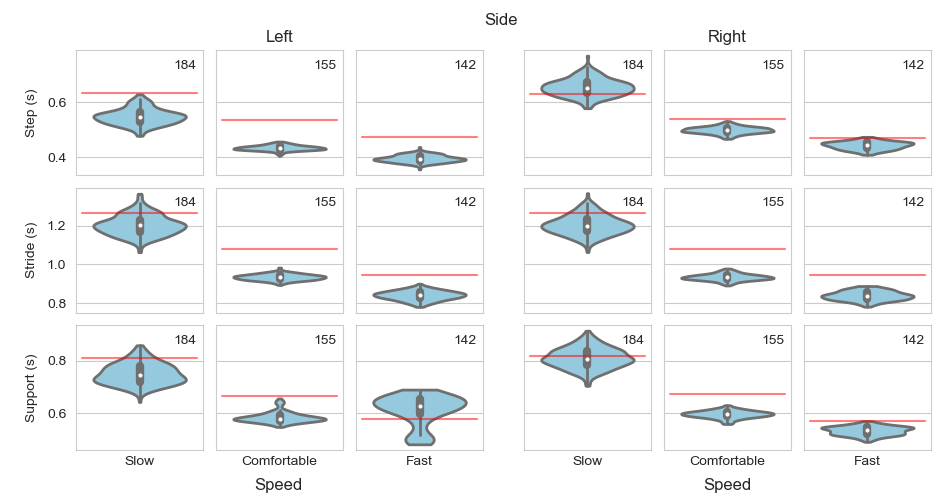

In [9]:
def plot_widget2(path2):
    """general plot widget of a pandas dataframe
    """
    from ipywidgets import widgets

    vars_str = ['step_l', 'stride_l', 'support_l', 'step_r', 'stride_r', 'support_r']
    
    filenames_c = glob.glob(os.path.join(path2, 'S*[0-9]', 's*c*ev.txt'), recursive=True)
    filenames_c.sort()
    filenames_f = glob.glob(os.path.join(path2, 'S*[0-9]', 's*f*ev.txt'), recursive=True)
    filenames_f.sort()
    filenames_s = glob.glob(os.path.join(path2, 'S*[0-9]', 's*s*ev.txt'), recursive=True)
    filenames_s.sort()

    fnames = [os.path.basename(fname) for fname in filenames_c]
    subjects = list(set([fname[:3] for fname in fnames]))
    subjects.insert(0, 'All subjects')
    subjects.sort()
    subject_w = widgets.Select(options=subjects, value=subjects[1], description='Subject',
                               layout=Layout(width='20%', height='80px'),
                               style = {'description_width': 'initial'})    
    container = widgets.HBox(children=[subject_w])

    display(container)
    # results for all subjects
    s = range(1, 23)
    vars_c_a, vars_f_a, vars_s_a = s_calc_vars2(s, filenames_c, filenames_f, filenames_s)
    
    fig = plt.figure(figsize=(9.5, 5))
    gs0 = gridspec.GridSpec(1, 2)
    gsl = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
    gsr = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[1])
    axs = np.empty((3, 6), dtype='O')
    for row in [0, 1, 2]:
        for col in [0, 1, 2]:
            axs[row, col] = plt.Subplot(fig, gsl[row, col], sharey=axs[row, 0])
            axs[row, col+3] = plt.Subplot(fig, gsr[row, col], sharey=axs[row, 0])
            if col == 0:
                fig.add_subplot(axs[row, col])
            else:
                fig.add_subplot(axs[row, col], sharex=axs[0, 0], sharey=axs[row, 0])
            fig.add_subplot(axs[row, col+3], sharex=axs[0, 0], sharey=axs[row, 0])
    
    #fig, axs = plt.subplots(3, 6, sharex=True, sharey='row', figsize=(9.5, 5))
    plt.tight_layout()
    plt.subplots_adjust(left=.08, right=.98, bottom = 0.1, top=.9, hspace=.1, wspace=.1)
    make_ticklabels(fig)
    plt.show()
    
    def plot(change):    
        for ax in axs.flatten():
            ax.clear()
        if subject_w.index==0:
            s = range(1, 23)
            #s = list(range(1, 19)) + list(range(20, 24))
        else:
            s = [subject_w.index-1]
        vars_c, vars_f, vars_s = s_calc_vars2(s, filenames_c, filenames_f, filenames_s)
        boxplot2(axs, vars_c, vars_f, vars_s, vars_str)
        if subject_w.index!=0:
            yy = np.ones(2)
            color = [1, 0, 0, .5]
            for row in range(3):    
                axs[row, 0].plot(axs[row, 0].get_xlim(), yy*np.median(vars_s_a[row]), color=color)
                axs[row, 1].plot(axs[row, 1].get_xlim(), yy*np.median(vars_c_a[row]), color=color)
                axs[row, 2].plot(axs[row, 2].get_xlim(), yy*np.median(vars_f_a[row]), color=color)
                axs[row, 3].plot(axs[row, 3].get_xlim(), yy*np.median(vars_s_a[row+3]), color=color)
                axs[row, 4].plot(axs[row, 4].get_xlim(), yy*np.median(vars_c_a[row+3]), color=color)
                axs[row, 5].plot(axs[row, 5].get_xlim(), yy*np.median(vars_f_a[row+3]), color=color)

    subject_w.observe(plot, names='value')
    plot(True)
    
plot_widget2(path2)

## Plot of spatio-temporal data per step (with widget to select subject)

<IPython.core.display.Javascript object>


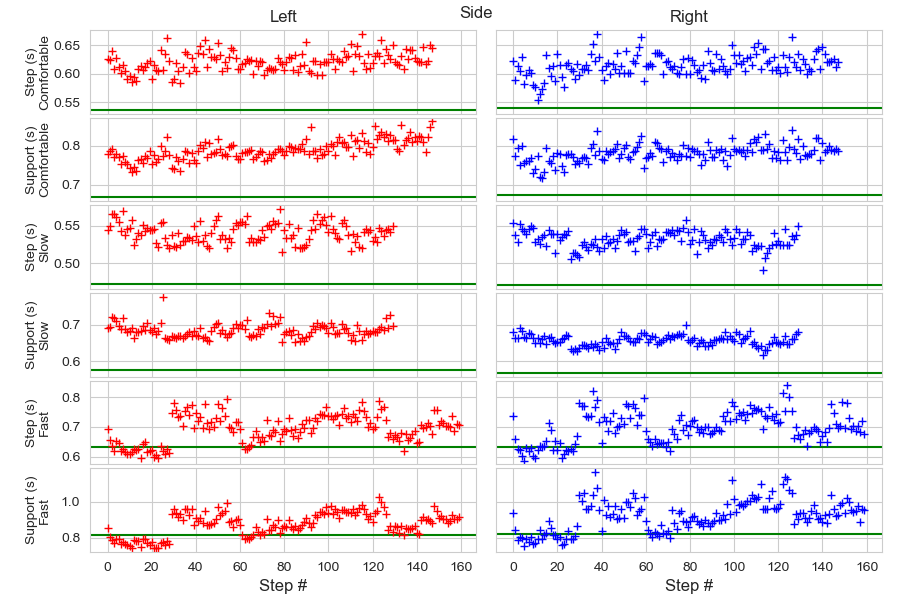

In [10]:
def plot_widget3(path2):
    """general plot widget of a pandas dataframe
    """
    from ipywidgets import widgets

    vars_str = ['step_l', 'stride_l', 'support_l', 'step_r', 'stride_r', 'support_r']
    
    filenames_c = glob.glob(os.path.join(path2, 'S*[0-9]', 's*c*ev.txt'), recursive=True)
    filenames_c.sort()
    filenames_f = glob.glob(os.path.join(path2, 'S*[0-9]', 's*f*ev.txt'), recursive=True)
    filenames_f.sort()
    filenames_s = glob.glob(os.path.join(path2, 'S*[0-9]', 's*s*ev.txt'), recursive=True)
    filenames_s.sort()

    fnames = [os.path.basename(fname) for fname in filenames_c]
    subjects = list(set([fname[:3] for fname in fnames]))
    subjects.sort()
    subject_w = widgets.Select(options=subjects, value=subjects[1], description='Subject',
                               layout=Layout(width='20%', height='80px'),
                               style = {'description_width': 'initial'})    
    container = widgets.HBox(children=[subject_w])

    display(container)
    # results for all healthy subjects
    s = range(1, len(subjects))
    vars_c_a, vars_f_a, vars_s_a = s_calc_vars(s, filenames_c, filenames_f, filenames_s)
    
    fig, axs = plt.subplots(6, 2, sharex=True, sharey='row', figsize=(9, 6))
    plt.tight_layout()
    plt.subplots_adjust(left=.1, right=.98, bottom = 0.08, top=.95, hspace=.05, wspace=.05)
    plt.show()
    
    def plot(change):    
        for ax in axs.flatten():
            ax.clear()
        s = [subject_w.index]
        vars_c, vars_f, vars_s = s_calc_vars(s, filenames_c, filenames_f, filenames_s)
        axs[0, 0].axhline(np.nanmedian(vars_c_a[0]), c='g')
        axs[0, 0].plot(vars_c[0], 'r+')
        axs[0, 1].axhline(np.nanmedian(vars_c_a[3]), c='g')
        axs[0, 1].plot(vars_c[3], 'b+')
        
        axs[1, 0].axhline(np.nanmedian(vars_c_a[2]), c='g')
        axs[1, 0].plot(vars_c[2], 'r+')
        axs[1, 1].axhline(np.nanmedian(vars_c_a[5]), c='g')
        axs[1, 1].plot(vars_c[5], 'b+')
        
        axs[2, 0].axhline(np.nanmedian(vars_f_a[0]), c='g')
        axs[2, 0].plot(vars_f[0], 'r+')
        axs[2, 1].axhline(np.nanmedian(vars_f_a[3]), c='g')
        axs[2, 1].plot(vars_f[3], 'b+')        

        axs[3, 0].axhline(np.nanmedian(vars_f_a[2]), c='g')
        axs[3, 0].plot(vars_f[2], 'r+')
        axs[3, 1].axhline(np.nanmedian(vars_f_a[5]), c='g')
        axs[3, 1].plot(vars_f[5], 'b+')        
        
        axs[4, 0].axhline(np.nanmedian(vars_s_a[0]), c='g')
        axs[4, 0].plot(vars_s[0], 'r+')
        axs[4, 1].axhline(np.nanmedian(vars_s_a[3]), c='g')
        axs[4, 1].plot(vars_s[3], 'b+')
                
        axs[5, 0].axhline(np.nanmedian(vars_s_a[2]), c='g')
        axs[5, 0].plot(vars_s[2], 'r+')
        axs[5, 1].axhline(np.nanmedian(vars_s_a[5]), c='g')
        axs[5, 1].plot(vars_s[5], 'b+')
        
        axs[0, 0].set_title('Left', fontsize=12)
        axs[0, 1].set_title('Right', fontsize=12)
        axs[5, 0].set_xlabel('Step #', fontsize=12)
        axs[5, 1].set_xlabel('Step #', fontsize=12)
        plt.figtext(x=.51, y=.97, s='Side', fontsize=12)
        
        vars_str = ['Step (s)', 'Support (s)', 'Step (s)', 'Support (s)', 'Step (s)', 'Support (s)']
        speed_str = ['Comfortable', 'Comfortable', 'Slow', 'Slow', 'Fast', 'Fast']
        for i in range(6):
            axs[i, 0].set_ylabel(vars_str[i]+'\n'+speed_str[i])
            axs[i, 0].locator_params(axis='y', tight=True, nbins=4)
            axs[i, 0].yaxis.set_label_coords(-.1, 0.5)
        
    subject_w.observe(plot, names='value')
    plot(True)
    
plot_widget3(path2)